# Cross-Entropy Method

---

In this notebook, we train the **Cross-Entropy Method** with OpenAI Gym's MountainCarContinuous environment.

Try different random seeds for environment and numpy.random to see the efect on training or stability of thre trained agent.

### 1. Import the Necessary Packages

In [38]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### 2. Instantiate the Environment and Agent

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCarContinuous-v0')

# Try different random seeds to see effect on training
env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

class Agent(nn.Module):
    ''' Agent build with a fully-connected neural network using pyTorch'''
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        ''' Setting weights (w) and bias (b)'''
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        
        # separate the weights and bias for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        ''' Getting weigths dimensions'''
        return (self.s_size + 1) * self.h_size + (self.h_size + 1) * self.a_size
        
    def forward(self, x):
        ''' Forwardpass of the agent'''
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        ''' Agent interaction with the environment = episode'''
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        # Timestep loop for every episode
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)   # from numpy array to torch tensor
            action = self.forward(state)                         # getting the action from the agent
            state, reward, done, _ = self.env.step(action)       # interaction with environment
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return
    
agent = Agent(env).to(device)    # initializing the agent 

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box([-1.], [1.], (1,), float32)
  - low: [-1.]
  - high: [1.]


### 3. Train the Agent with the Cross-Entropy Method

Run the code cells below to train the agent from scratch. Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

In [40]:
# Cross-Entropy Method
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size * elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    best_weight = sigma * np.random.randn(agent.get_weights_dim())   # first random weights
    
    # Episode loop (timestep loop inside agent.evaluate class function)
    for i_iteration in range(1, n_iterations+1):
        weights_pop = [best_weight + (sigma * np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        # Cross-Entropy application
        elite_idxs = rewards.argsort()[-n_elite:]             # identification index of elite population
        elite_weights = [weights_pop[i] for i in elite_idxs]  # getting weights of elite population
        best_weight = np.array(elite_weights).mean(axis=0)    # taking the average of elite population weights

        reward = agent.evaluate(best_weight, gamma=1.0)       # reward for the previously calculated best weights
        scores_deque.append(reward)
        scores.append(reward)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

Episode 10	Average Score: -1.44
Episode 20	Average Score: -3.98
Episode 30	Average Score: -4.18
Episode 40	Average Score: 2.57
Episode 50	Average Score: 18.74
Episode 60	Average Score: 29.35
Episode 70	Average Score: 38.69
Episode 80	Average Score: 45.65
Episode 90	Average Score: 47.98
Episode 100	Average Score: 52.56
Episode 110	Average Score: 62.09
Episode 120	Average Score: 72.28
Episode 130	Average Score: 82.21
Episode 140	Average Score: 89.48

Environment solved in 47 iterations!	Average Score: 90.83


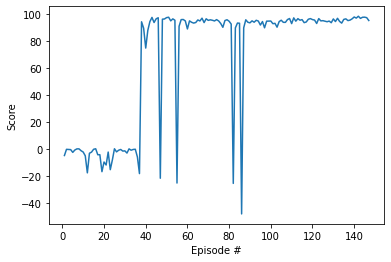

In [41]:
# Training
scores = cem()

# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In [56]:
# load the weights from checkpoint.pth file
agent.load_state_dict(torch.load('checkpoint.pth'))

state = env.reset()
env.seed(np.random.randint(low=0, high=100))  # Random seed to test stability.

while True:
    state = torch.from_numpy(state).float().to(device)
    with torch.no_grad():
        action = agent(state)
        actions.append(action)
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

### 6. And compare with a Random Agent

In [52]:
state = env.reset()
env.seed(np.random.randint(low=0, high=100))  # Random seed to test stability.
while True:
    state = torch.from_numpy(state).float().to(device)
    action = torch.from_numpy(np.array(np.random.uniform(low=-1.0, high=1.0)))  # random actions
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()